# Линейные методы

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Для воспроизводимости результатов
np.random.seed(42)

sns.set_theme(style='whitegrid')

# 1. Подготовка данных

In [16]:
# Загрузка набора данных
data = load_breast_cancer()
X = data.data
y = data.target

print("Значения целевого признака:", np.unique(data.target))

# В датасете 2 класса 0 или 1, мы, в соответствии с условием задачи, меняем 0 на -1
y = np.where(y == 0, -1, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Значения целевого признака: [0 1]
Размер обучающей выборки: (455, 30)
Размер тестовой выборки: (114, 30)


## 2. Линейная регрессия

In [17]:
def linear_regression_ridge(X, y, reg_lambda=1.0):
    n_features = X.shape[1]
    I = np.eye(n_features)
    w = np.linalg.inv(X.T @ X + reg_lambda * I) @ X.T @ y
    return w

def predict_linear_regression(X, w):
    preds = np.sign(X @ w)
    preds[preds == 0] = 1
    return preds

reg_lambda = 1.0
w_ridge = linear_regression_ridge(X_train, y_train, reg_lambda)

y_pred_lr = predict_linear_regression(X_test, w_ridge)
acc_lr = np.mean(y_pred_lr == y_test)
print('Точность классификатора на основе ridge-регрессии:', acc_lr)

# Также вычисляем среднеквадратичную ошибку (MSE) как функцию ошибки
def mse_loss(X, y, w):
    preds = X @ w
    return np.mean((y - preds) ** 2)

mse_test_lr = mse_loss(X_test, y_test, w_ridge)
print('MSE ridge-регрессии на тестовом наборе:', mse_test_lr)

Точность классификатора на основе ridge-регрессии: 0.9385964912280702
MSE ridge-регрессии на тестовом наборе: 0.3429432247534692


## 3. Линейный классификатор на основе градиентного спуска

Функции эмпирического риска:

 - **Функция потерь Хинджа (Hinge Loss)**
 - **Логистическая функция потерь (Logistic Loss)**
 - **Квадратичная функция потерь Хинджа (Squared Hinge Loss)**

In [18]:
def compute_loss_and_grad(X, y, w, loss_type='hinge', lambda1=0.01, lambda2=0.01):
    n_samples = X.shape[0]
    margins = y * (X @ w)
    loss = 0.0
    grad = np.zeros_like(w)

    if loss_type == 'hinge':
        loss_terms = np.maximum(0, 1 - margins)
        loss = np.mean(loss_terms)
        indicator = (loss_terms > 0).astype(float)
        grad = - (1 / n_samples) * (X.T @ (indicator * y))
    elif loss_type == 'logistic':
        loss_terms = np.log(1 + np.exp(-margins))
        loss = np.mean(loss_terms)
        sigmoid = 1 / (1 + np.exp(margins))
        grad = - (1 / n_samples) * (X.T @ (y * sigmoid))
    elif loss_type == 'squared_hinge':
        loss_terms = np.maximum(0, 1 - margins)
        loss = np.mean(loss_terms ** 2)
        indicator = (loss_terms > 0).astype(float)
        grad = - (2 / n_samples) * (X.T @ (indicator * y * (1 - margins)))
    else:
        raise ValueError('Unsupported loss function.')

    # Регуляризация Elastic Net
    reg_loss = lambda1 * np.sum(np.abs(w)) + lambda2 * np.sum(w ** 2)
    loss += reg_loss

    # Субградиент для L1 это sign(w), а для L2 это 2*w
    reg_grad = lambda1 * np.sign(w) + 2 * lambda2 * w
    grad += reg_grad

    return loss, grad

def gradient_descent_classifier(X, y, loss_type='hinge', lambda1=0.01, lambda2=0.01,
                                learning_rate=0.1, n_iters=1000, verbose=False):
    n_features = X.shape[1]
    w = np.zeros(n_features)
    loss_history = []

    for i in range(n_iters):
        loss, grad = compute_loss_and_grad(X, y, w, loss_type=loss_type, lambda1=lambda1, lambda2=lambda2)
        w = w - learning_rate * grad
        loss_history.append(loss)
        if verbose and i % 100 == 0:
            print(f"Итерация {i}: Потери = {loss}")
    
    return w, loss_history

w_gd, loss_history_gd = gradient_descent_classifier(X_train, y_train, loss_type='logistic', 
                                                     lambda1=0.001, lambda2=0.001,
                                                     learning_rate=0.1, n_iters=500, verbose=True)

def predict_linear_classifier(X, w):
    preds = np.sign(X @ w)
    preds[preds == 0] = 1
    return preds

y_pred_gd = predict_linear_classifier(X_test, w_gd)
acc_gd = np.mean(y_pred_gd == y_test)
print('Точность классификатора на основе градиентного спуска (логистическая функция потерь):', acc_gd)

Итерация 0: Потери = 0.6931471805599453
Итерация 100: Потери = 0.12172459773176543
Итерация 200: Потери = 0.10522851441189791
Итерация 300: Потери = 0.09853527180875536
Итерация 400: Потери = 0.0948201454892009
Точность классификатора на основе градиентного спуска (логистическая функция потерь): 0.9824561403508771


## 4. Метод опорных векторов через градиентный спуск

Ядерные функции:

- **Линейное ядро**
- **Полиномиальное ядро**
- **Гауссово (RBF) ядро**

In [19]:
def linear_kernel(X1, X2):
    return X1 @ X2.T

def polynomial_kernel(X1, X2, degree=3, coef0=1):
    return (X1 @ X2.T + coef0) ** degree

def rbf_kernel(X1, X2, gamma=0.1):
    if X1.ndim == 1:
        X1 = X1.reshape(1, -1)
    if X2.ndim == 1:
        X2 = X2.reshape(1, -1)
    X1_sq = np.sum(X1 ** 2, axis=1).reshape(-1, 1)
    X2_sq = np.sum(X2 ** 2, axis=1).reshape(1, -1)
    dists = X1_sq + X2_sq - 2 * (X1 @ X2.T)
    return np.exp(-gamma * dists)

def svm_gradient_descent(X, y, kernel='linear', kernel_params={}, 
                         learning_rate=0.001, n_iters=1000, C=1.0, verbose=False):
    n_samples = X.shape[0]
    alpha = np.zeros(n_samples)  # двойственные переменные

    # Вычисление матрицы ядра
    if kernel == 'linear':
        K = linear_kernel(X, X)
    elif kernel == 'polynomial':
        degree = kernel_params.get('degree', 3)
        coef0 = kernel_params.get('coef0', 1)
        K = polynomial_kernel(X, X, degree=degree, coef0=coef0)
    elif kernel == 'rbf':
        gamma = kernel_params.get('gamma', 0.1)
        K = rbf_kernel(X, X, gamma=gamma)
    else:
        raise ValueError('Unsupported kernel type')

    loss_history = []
    
    for it in range(n_iters):
        # Вычисление градиента двойственной целевой функции по alpha
        grad = np.ones(n_samples) - (K * (y.reshape(-1, 1) * y.reshape(1, -1))) @ alpha
        
        # Обновление градиентного подъема (так как мы максимизируем двойственную функцию)
        alpha = alpha + learning_rate * grad
        
        # Восстановление ограничений: проекция alpha на [0, C]
        alpha = np.clip(alpha, 0, C)
        
        # Запись отрицательной двойственной функции (негативной, как потери) для построения графика
        dual_obj = np.sum(alpha) - 0.5 * alpha @ ((K * (y.reshape(-1, 1) * y.reshape(1, -1))) @ alpha)
        loss_history.append(-dual_obj)
        
        if verbose and it % 100 == 0:
            print(f"Итерация {it}: Двойственная целевая функция = {dual_obj}")
    
    # Для линейного ядра мы можем восстановить вектор весов w
    if kernel == 'linear':
        w = ((alpha * y).reshape(-1, 1) * X).sum(axis=0)
    else:
        w = None
    
    model = {
        'alpha': alpha,
        'X_train': X,
        'y_train': y,
        'kernel': kernel,
        'kernel_params': kernel_params,
        'w': w
    }
    
    return model, loss_history

def svm_predict(model, X):
    kernel = model['kernel']
    X_train = model['X_train']
    y_train = model['y_train']
    alpha = model['alpha']
    
    if kernel == 'linear' and model['w'] is not None:
        preds = np.sign(X @ model['w'])
    else:
        if kernel == 'linear':
            K = linear_kernel(X, X_train)
        elif kernel == 'polynomial':
            degree = model['kernel_params'].get('degree', 3)
            coef0 = model['kernel_params'].get('coef0', 1)
            K = polynomial_kernel(X, X_train, degree=degree, coef0=coef0)
        elif kernel == 'rbf':
            gamma = model['kernel_params'].get('gamma', 0.1)
            K = rbf_kernel(X, X_train, gamma=gamma)
        else:
            raise ValueError('Неизвестное ядро')
        
        # Решающая функция вычисляется в двойственной форме
        decision = (alpha * y_train) @ K.T
        preds = np.sign(decision)
    
    preds[preds == 0] = 1
    return preds

svm_model_linear, loss_history_svm_linear = svm_gradient_descent(X_train, y_train, kernel='linear', 
                                                                  learning_rate=0.001, n_iters=500, C=1.0, verbose=True)

svm_model_poly, loss_history_svm_poly = svm_gradient_descent(X_train, y_train, kernel='polynomial', 
                                                              kernel_params={'degree': 3, 'coef0': 1}, 
                                                              learning_rate=0.001, n_iters=500, C=1.0, verbose=False)

svm_model_rbf, loss_history_svm_rbf = svm_gradient_descent(X_train, y_train, kernel='rbf', 
                                                            kernel_params={'gamma': 0.1}, 
                                                            learning_rate=0.001, n_iters=500, C=1.0, verbose=False)

y_pred_svm_linear = svm_predict(svm_model_linear, X_test)
acc_svm_linear = np.mean(y_pred_svm_linear == y_test)
print('Точность SVM (Линейное ядро):', acc_svm_linear)

y_pred_svm_poly = svm_predict(svm_model_poly, X_test)
acc_svm_poly = np.mean(y_pred_svm_poly == y_test)
print('Точность SVM (Полиномиальное ядро):', acc_svm_poly)

y_pred_svm_rbf = svm_predict(svm_model_rbf, X_test)
acc_svm_rbf = np.mean(y_pred_svm_rbf == y_test)
print('Точность SVM (Ядро RBF):', acc_svm_rbf)

Итерация 0: Двойственная целевая функция = -0.352000824207108
Итерация 100: Двойственная целевая функция = -56570.39531681014
Итерация 200: Двойственная целевая функция = -57047.51061782955
Итерация 300: Двойственная целевая функция = -57069.23427029214
Итерация 400: Двойственная целевая функция = -57065.99964785196
Точность SVM (Линейное ядро): 0.39473684210526316
Точность SVM (Полиномиальное ядро): 0.39473684210526316
Точность SVM (Ядро RBF): 0.956140350877193


## 5. Оптимизация гиперпараметров и кривые обучения

Лучшие гиперпараметры для классификатора на основе градиентного спуска: {'learning_rate': 0.1, 'lambda1': 0.001, 'lambda2': 0.001} с точностью: 0.9824561403508771
Лучшие гиперпараметры для SVM: {'learning_rate': 0.01, 'gamma': 0.001} с точностью: 0.40350877192982454


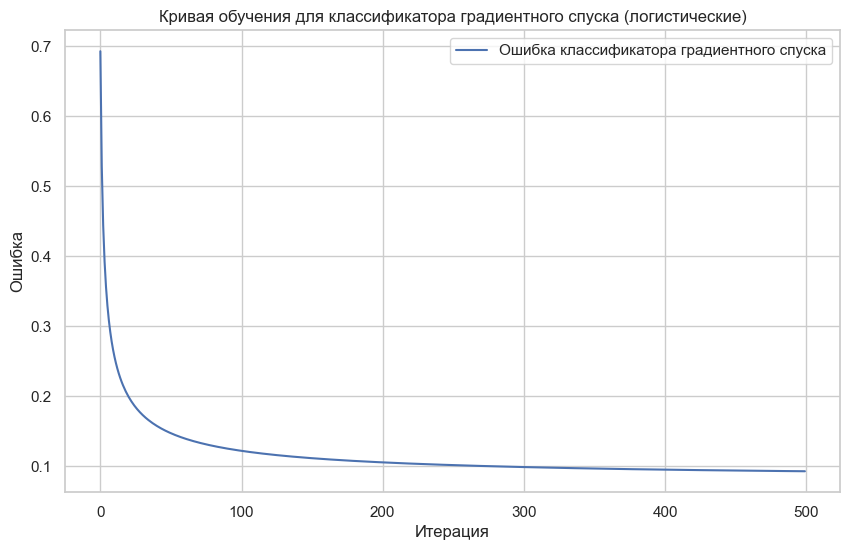

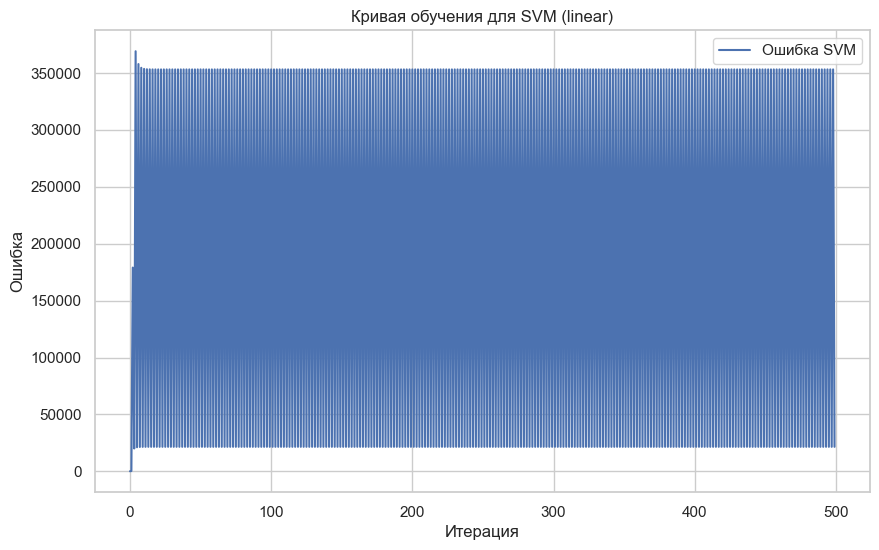

Точность классификатора градиентного спуска: Среднее = 0.977, Стд = 0.010
Точность SVM: Среднее = 0.483, Стд = 0.040


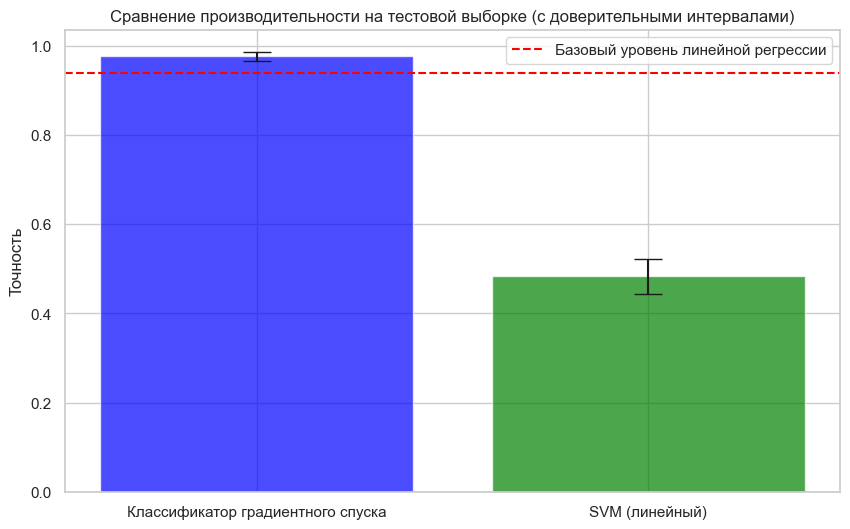

In [20]:
learning_rates = [0.01, 0.05, 0.1]
lambda1_values = [0.001, 0.01]
lambda2_values = [0.001, 0.01]

best_acc = 0
best_params = {}

for lr in learning_rates:
    for l1 in lambda1_values:
        for l2 in lambda2_values:
            w_tmp, loss_hist_tmp = gradient_descent_classifier(X_train, y_train, loss_type='logistic', 
                                                                 lambda1=l1, lambda2=l2, 
                                                                 learning_rate=lr, n_iters=500, verbose=False)
            y_pred_tmp = predict_linear_classifier(X_test, w_tmp)
            acc_tmp = np.mean(y_pred_tmp == y_test)
            if acc_tmp > best_acc:
                best_acc = acc_tmp
                best_params = {'learning_rate': lr, 'lambda1': l1, 'lambda2': l2}

gamma_values = [0.01, 0.1, 1.0]

svm_best_acc = 0
svm_best_params = {}

for lr in learning_rates:
    for ga in lambda1_values:
        w_tmp, loss_hist_tmp = svm_gradient_descent(X_train, y_train, kernel='linear', 
                                                        kernel_params={'gamma': ga}, 
                                                        learning_rate=lr, n_iters=500, C=1.0, verbose=False)
        y_pred_tmp = svm_predict(w_tmp, X_test)
        acc_tmp = np.mean(y_pred_tmp == y_test)
        if acc_tmp > svm_best_acc:
            svm_best_acc = acc_tmp
            svm_best_params = {'learning_rate': lr, 'gamma': ga}

print('Лучшие гиперпараметры для классификатора на основе градиентного спуска:', best_params, 'с точностью:', best_acc)
print('Лучшие гиперпараметры для SVM:', svm_best_params, 'с точностью:', svm_best_acc)

w_best, loss_history_best = gradient_descent_classifier(X_train, y_train, loss_type='logistic', 
                                                        lambda1=best_params['lambda1'], 
                                                        lambda2=best_params['lambda2'], 
                                                        learning_rate=best_params['learning_rate'], 
                                                        n_iters=500, verbose=False)

svm_w_best, svm_loss_history_best = svm_gradient_descent(X_train, y_train, kernel='linear', 
                                                        kernel_params={'gamma': svm_best_params['gamma']}, 
                                                        learning_rate=svm_best_params['learning_rate'], n_iters=500, C=1.0, verbose=False)

plt.figure(figsize=(10, 6))
plt.plot(loss_history_best, label='Ошибка классификатора градиентного спуска')
plt.xlabel('Итерация')
plt.ylabel('Ошибка')
plt.title('Кривая обучения для классификатора градиентного спуска (логистические)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(svm_loss_history_best, label='Ошибка SVM')
plt.xlabel('Итерация')
plt.ylabel('Ошибка')
plt.title('Кривая обучения для SVM (linear)')
plt.legend()
plt.show()

n_splits = 10
accs_gd = []
accs_svm = []

for i in range(n_splits):
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.2, random_state=42 + i)
    
    w_tmp, _ = gradient_descent_classifier(X_tr, y_tr, loss_type='logistic', 
                                           lambda1=best_params['lambda1'], lambda2=best_params['lambda2'], 
                                           learning_rate=best_params['learning_rate'], n_iters=500, verbose=False)
    y_pred_tmp = predict_linear_classifier(X_te, w_tmp)
    accs_gd.append(np.mean(y_pred_tmp == y_te))
    
    svm_model_tmp, _ = svm_gradient_descent(X_tr, y_tr, kernel='linear', 
                                            kernel_params={'gamma': svm_best_params['gamma']},
                                            learning_rate=svm_best_params['learning_rate'], n_iters=500, C=1.0, verbose=False)
    y_pred_svm_tmp = svm_predict(svm_model_tmp, X_te)
    accs_svm.append(np.mean(y_pred_svm_tmp == y_te))

accs_gd = np.array(accs_gd)
accs_svm = np.array(accs_svm)

print('Точность классификатора градиентного спуска: Среднее = {:.3f}, Стд = {:.3f}'.format(np.mean(accs_gd), np.std(accs_gd)))
print('Точность SVM: Среднее = {:.3f}, Стд = {:.3f}'.format(np.mean(accs_svm), np.std(accs_svm)))

# Построение графика производительности на тестовой выборке с доверительными интервалами
models = ['Классификатор градиентного спуска', 'SVM (линейный)']
means = [np.mean(accs_gd), np.mean(accs_svm)]
stds = [np.std(accs_gd), np.std(accs_svm)]

plt.figure(figsize=(10, 6))
plt.bar(models, means, yerr=stds, capsize=10, alpha=0.7, color=['blue', 'green'])
plt.axhline(acc_lr, color='red', linestyle='--', label='Базовый уровень линейной регрессии')
plt.ylabel('Точность')
plt.title('Сравнение производительности на тестовой выборке (с доверительными интервалами)')
plt.legend()
plt.show()